![logo](./img/LogoLine_horizon_C3S.png)

# Tutorial on total precipitation using CARRA data

### About

In this tutorial we will access data from the Climate Data Store (CDS) of the Copernicus Climate Change Service (C3S), and analyse total precipitation. The tutorial comprises the following steps:

1. Search, download and view data for a given day in June 2023 for CARRA and ERA5
2. Calculate total precipitation accumulations
3. Visualize the total precipitation over Greenland
4. Visualise the total sum of precipitation over Greenland


<style>
td, th {
   border: 1px solid white;
   border-collapse: collapse;
}
</style>
<table align="left">
  <tr>
    <th>Run the tutorial via free cloud platforms: </th>
    <th><a href="https://mybinder.org/v2/gh/carlos9917/carra-training-c3s/main?labpath=CARRA_ERA5_total_precipitation.ipynb">
        <img src = "https://mybinder.org/badge.svg" alt = "Binder"></th>
    <th><a href="https://kaggle.com/kernels/welcome?src=https://github.com/carlos9917/carra-training-c3s/blob/main/CARRA_ERA5_total_precipitation.ipynb">
        <img src = "https://kaggle.com/static/images/open-in-kaggle.svg" alt = "Kaggle"></th>
    <th><a href="https://colab.research.google.com/github/carlos9917/carra-training-c3s/blob/main/CARRA_ERA5_total_precipitation.ipynb">
        <img src = "https://colab.research.google.com/assets/colab-badge.svg" alt = "Colab"></th>
  </tr>
</table>

In [29]:
import cdsapi
c = cdsapi.Client()
import datetime
import os

# Libraries for working with multidimensional arrays
import numpy as np
import xarray as xr

# Libraries for plotting and visualising data
import matplotlib.pyplot as plt
import matplotlib.colors as colors

import cartopy.crs as ccrs


In [30]:
def fetching(year, mon, day, time, leadtime, DATADIR):
    if isinstance(day, list):
        fday = day[0]
    else:
        fday = day

    target_file = os.path.join(DATADIR,'Precipitation_fc_'+str(year)+"{:02d}".format(mon)+"{:02d}".format(fday)+"{:02d}".format(time)+'.grb'
                              )   
    if not os.path.isfile(target_file):
        c.retrieve(
        'reanalysis-carra-single-levels',
        {
            'format': 'grib',
            'domain': 'west_domain',
            'level_type': 'surface_or_atmosphere',
            'variable': 'total_precipitation',
            'product_type': 'forecast',
            'time': time,
            'leadtime_hour': leadtime,
            'year': year,
            'month': mon,
            'day': day,
        },
        target_file)
    else:
        print(f"{target_file} already downloaded")


In [32]:
print ("Fetching the data...")
temp_dir = "CARRA"
if not os.path.isdir(temp_dir):
    os.makedirs(temp_dir)

DATADIR = temp_dir

#DATADIR = '/ec/res4/scratch/smos/CARRA/Raw_data/'
fetching(2023, 5, 31, 12, [12, 18], DATADIR)
days = [x for x in range(1,31)]
fetching(2023, 6, days, 12, [6, 12, 18], DATADIR)
fetching(2023, 6, days, 0, [6, 18], DATADIR)


Fetching the data...
CARRA/Precipitation_fc_2023053112.grb already downloaded
CARRA/Precipitation_fc_2023060112.grb already downloaded
CARRA/Precipitation_fc_2023060100.grb already downloaded


In [33]:
# Calculate the daily sums with help of CDO 
from cdo import *
cdo   = Cdo()

#indata='/ec/res4/scratch/smos/CARRA/Raw_data/'
indata = "CARRA/"
outdata = "Daily_means/"
if not os.path.isdir(outdata):
    os.makedirs(outdata)

#outdata='/ec/res4/scratch/smos/CARRA/Daily_means/'
#indata = ""

cdo.splithour(input=indata+'Precipitation_fc_2023053112.grb', output=outdata+'Precipitation_fc_20230531_')
cdo.splithour(input=indata+'Precipitation_fc_2023060100.grb', output=outdata+'Precipitation_fc_2023060100_')
cdo.splithour(input=indata+'Precipitation_fc_2023060112.grb', output=outdata+'Precipitation_fc_2023060112_')

file1 = outdata+'Precipitation_fc_2023060112_06.grb '
file2 = outdata+'Precipitation_fc_2023060112_00.grb'
inputstring=file1+file2
cdo.sub(input=inputstring, output=outdata+'Precipitation_202306_00-06UTC.grb')

file1 = outdata+'Precipitation_fc_2023060100_18.grb '
file2 = outdata+'Precipitation_fc_2023060100_06.grb'
inputstring=file1+file2
cdo.sub(input=inputstring, output=outdata+'Precipitation_202306_06-18UTC.grb')

file1 = " -shifttime,-1minute "+outdata+'Precipitation_fc_2023060112_00.grb '
file2 = outdata+'Precipitation_fc_2023060112_18.grb'
inputstring=file1+file2
cdo.sub(input=inputstring, output=outdata+'Precipitation_202306_18-24UTC.grb')

file1 = outdata+'Precipitation_fc_20230531_06.grb '
file2 = outdata+'Precipitation_fc_20230531_00.grb'
inputstring=file1+file2
cdo.sub(input=inputstring, output=outdata+'Precipitation_20230601_00-06UTC.grb')

inputstring=" -selmon,6 -mergetime "+outdata+'Precipitation_20230601_00-06UTC.grb '+outdata+'Precipitation_202306_06-18UTC.grb '+outdata+'Precipitation_202306_18-24UTC.grb '+outdata+'Precipitation_202306_00-06UTC.grb '
cdo.daysum(input=inputstring, output=outdata+'Precipitation_202306_daysum.grb')

## ??? Carlos/Martin
#  There are negative values for the computed daily sums! Why?
#  Could be fixed with CDO

## ??? Carlos/Martin
#  The CDO change the parameter name from "total precipitation" to "precipitation rate" for unknown reason.
#  How should we handle this?

'Daily_means/Precipitation_202306_daysum.grb'

In [25]:
# Now, download ERA5 precipitation and compute daily sums
area_greenland = [85,-110,50,30]
#DATADIR = '/ec/res4/scratch/smos/CARRA/'
DATADIR= "ERA5/"
if not os.path.isdir(DATADIR):
    os.makedirs(DATADIR)
target_file = os.path.join(DATADIR,'ERA5_tp_202306_hourly.grb')

if not os.path.isfile(target_file):
    c.retrieve(
        'reanalysis-era5-single-levels',
    {
        'product_type': 'reanalysis',
        'format': 'grib',
        'variable': 'total_precipitation',
        'year': '2023',
        'month': '06',
        'day': [
            '01', '02', '03',
            '04', '05', '06',
            '07', '08', '09',
            '10', '11', '12',
            '13', '14', '15',
            '16', '17', '18',
            '19', '20', '21',
            '22', '23', '24',
            '25', '26', '27',
            '28', '29', '30',
        ],
        'time': [
            '00:00', '01:00', '02:00',
            '03:00', '04:00', '05:00',
            '06:00', '07:00', '08:00',
            '09:00', '10:00', '11:00',
            '12:00', '13:00', '14:00',
            '15:00', '16:00', '17:00',
            '18:00', '19:00', '20:00',
            '21:00', '22:00', '23:00',
        ],
        'area': area_greenland,
    },
    target_file)
else:
    print(f"{target_file} already downloaded")

# Compute daysum with CDO
cdo.daysum(input=" -mulc,1000 "+target_file, output=DATADIR+'ERA5_tp_202306_daysum.grb')

ERA5/ERA5_tp_202306_hourly.grb already downloaded


'ERA5/ERA5_tp_202306_daysum.grb'

Ignoring index file 'Daily_means/Precipitation_202306_daysum.grb.923a8.idx' older than GRIB file


Frozen({'step': 30, 'y': 1269, 'x': 1069})
Compute the mean
Frozen({'y': 1269, 'x': 1069})
Done.


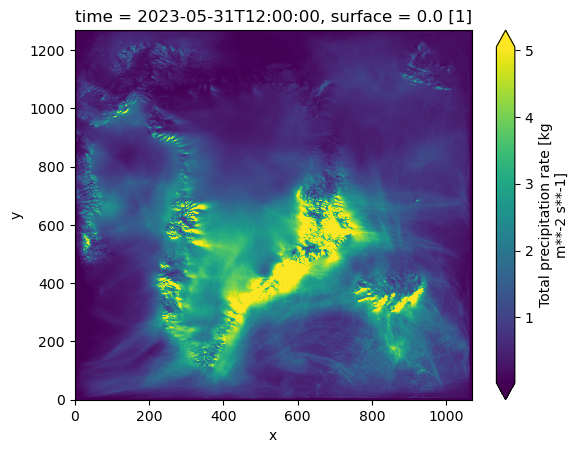

In [34]:
# Plot CARRA
#DATADIR = '/ec/res4/scratch/smos/CARRA'
DATADIR= "CARRA/"

fCARRA = f'Daily_means/Precipitation_202306_daysum.grb'

### Open Datasets
#CARRA
CARRA = xr.open_dataset(fCARRA)
print(CARRA.dims)

# Compute monthly mean
print("Compute the mean")
CARRA_mean = CARRA.mean(dim="step", keep_attrs=True)
print(CARRA_mean.dims)
print("Done.")

# Change longitudes from 0-360 to -180 to +180, needed for the plotting
CARRA_mean = CARRA_mean.assign_coords(longitude=(((CARRA_mean.longitude + 180) % 360) - 180))


# Create "Xarray Data Array" from "Xarray Dataset"
#print(CARRA_mean.variables)
CARRA_da = CARRA_mean['tprate']


# Simple plot
CARRA_da.plot(robust=True)
#CARRA_da.plot(levels=[0,0.5,1,2,3,5,10])
#plt.savefig(f'{DATADIR}/Figures/CARRA_west_202306_simple.png')
plt.show()



Frozen({'time': 30, 'latitude': 141, 'longitude': 561})
Compute the mean
Frozen({'latitude': 141, 'longitude': 561})
Done.


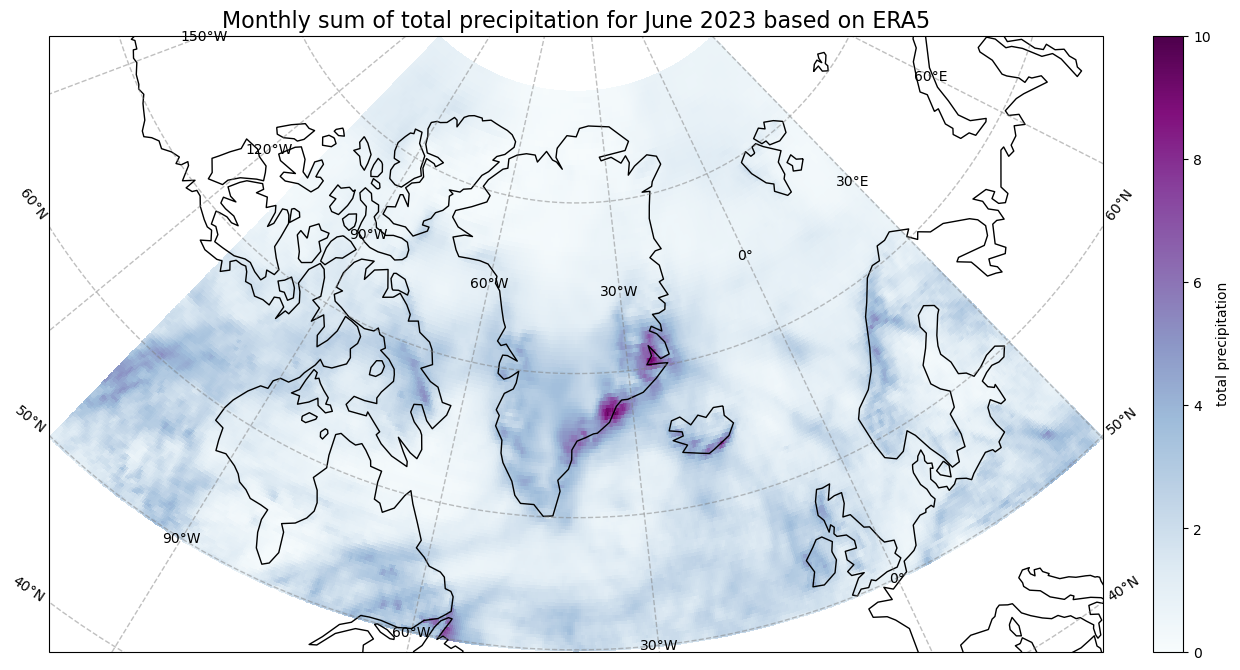

In [35]:
# Plot ERA5
DATADIR = 'ERA5'
fERA5 = f'{DATADIR}/ERA5_tp_202306_daysum.grb'

### Open Dataset
ERA5 = xr.open_dataset(fERA5)
print(ERA5.dims)

# Compute monthly mean
print("Compute the mean")
ERA5_mean = ERA5.mean(dim="time", keep_attrs=True)
print(ERA5_mean.dims)
print("Done.")

# Change longitudes from 0-360 to -180 to +180, needed for the plotting
ERA5_mean = ERA5_mean.assign_coords(longitude=(((ERA5_mean.longitude + 180) % 360) - 180))


# Create "Xarray Data Array" from "Xarray Dataset"
#print(CARRA_mean.variables)
ERA5_da = ERA5_mean['tp']


fig, ax = plt.subplots(1, 1, figsize = (16, 8), subplot_kw={'projection': ccrs.LambertConformal(central_latitude=70.0, central_longitude=-40.0)})

# Plot the data
im = plt.pcolormesh(ERA5_da.longitude, ERA5_da.latitude, ERA5_da, transform = ccrs.PlateCarree(), cmap='BuPu', vmin=0, vmax=10) 
#im = plt.pcolormesh(CARRA_da.longitude, CARRA_da.latitude, CARRA_da, transform = ccrs.PlateCarree(), cmap='RdBu_r', norm=colors.LogNorm(vmin=0, vmax=6))

# Set the figure title
ax.set_title('Monthly sum of total precipitation for June 2023 based on ERA5', fontsize=16)
ax.coastlines(color='black')
ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--') 

# Specify the colourbar
cbar = plt.colorbar(im,fraction=0.05, pad=0.04)
cbar.set_label('total precipitation') 

# Save the figure
plt.show()
#fig.savefig(f'{DATADIR}/Figures/CARRA_west_202306_monthly_mean_precipitation.png')

In [40]:
# Plot difference between CARRA and ERA5
# Interpolate ERA5 onto the CARRA grid, again with the help of CDO
cdo.remapbil('./Daily_means/Precipitation_202306_daysum.grb', input='./ERA5/ERA5_tp_202306_daysum.grb', output='./ERA5/ERA5_tp_202306_daysum_CARRA_grid.grb')

# Read and prepare the interpolated data for plotting
fERA5 = f'ERA5/ERA5_tp_202306_daysum_CARRA_grid.grb'

### Open Dataset
ERA5 = xr.open_dataset(fERA5)
print(ERA5.dims)

# Compute monthly mean
print("Compute the mean")
ERA5_mean = ERA5.mean(dim="time", keep_attrs=True)
print(ERA5_mean.dims)
print("Done.")

# Change longitudes from 0-360 to -180 to +180, needed for the plotting
ERA5_mean = ERA5_mean.assign_coords(longitude=(((ERA5_mean.longitude + 180) % 360) - 180))


# Create "Xarray Data Array" from "Xarray Dataset"
#print(CARRA_mean.variables)
ERA5_da = ERA5_mean['tp']

Frozen({'time': 30, 'y': 1269, 'x': 1069})
Compute the mean
Frozen({'y': 1269, 'x': 1069})
Done.


/home/cperalta/mambaforge-pypy3/envs/dataviz/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1781: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  result = super().pcolormesh(*args, **kwargs)
/home/cperalta/mambaforge-pypy3/envs/dataviz/lib/python3.9/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


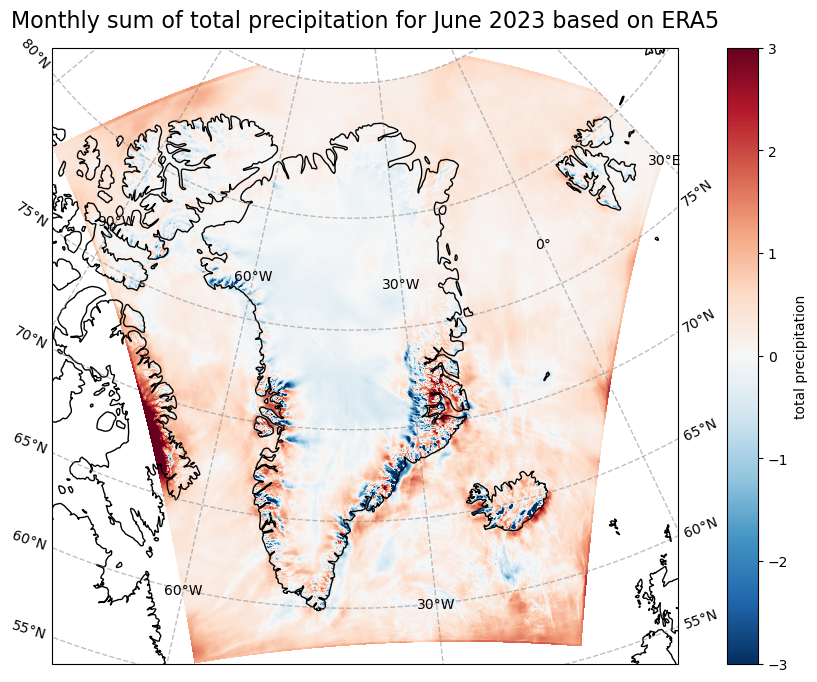

In [41]:
# Plotting
fig, ax = plt.subplots(1, 1, figsize = (16, 8), subplot_kw={'projection': ccrs.LambertConformal(central_latitude=70.0, central_longitude=-40.0)})

# Plot the data
im = plt.pcolormesh(ERA5_da.longitude, ERA5_da.latitude, ERA5_da-CARRA_da, transform = ccrs.PlateCarree(), cmap='RdBu_r', vmin=-3, vmax=3) 
#im = plt.pcolormesh(CARRA_da.longitude, CARRA_da.latitude, CARRA_da, transform = ccrs.PlateCarree(), cmap='RdBu_r', norm=colors.LogNorm(vmin=0, vmax=6))

# Set the figure title
ax.set_title('Monthly sum of total precipitation for June 2023 based on ERA5', fontsize=16)
ax.coastlines(color='black')
ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--') 

# Specify the colourbar
cbar = plt.colorbar(im,fraction=0.05, pad=0.04)
cbar.set_label('total precipitation') 

# Save the figure
plt.show()